In [1]:
import os

import climlab
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from tqdm import tqdm

SEED = 42
np.random.seed(SEED)

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl"
DATASETS_DIR = f"{BASE_DIR}/datasets"

fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath,
            decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
).sortby("lat")

lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

Loading NCEP surface temperature data ...


In [3]:
a0_ref = 0.354
a2_ref = 0.25
D_ref = 0.6
A_ref = 2.1
B_ref = 2.0

num_lat = len(Ts_ncep_annual)

nSteps_Episode = 200
nSteps = nSteps_Episode * 10
nEnsembles = 100

In [4]:
climlab_ebm = climlab.EBM_annual(
    a0=a0_ref,
    a2=a2_ref,
    D=D_ref,
    A=A_ref * 1e2,  # effective A (around 210)
    B=A_ref,
    num_lat=num_lat,
)
climlab_ebm.Ts[:] = 50.0  # initialise temperature state

for i in range(nSteps):
    climlab_ebm.step_forward()

In [5]:
class Forecast:
    def __init__(self):
        self.zforecast = None


forecast = Forecast()


def hx(x):
    """
    Measurement function for EnKF.
    """
    return forecast.zforecast


def fx(x, dt):
    """
    State transition function (identity, as process noise is added via Q).
    """
    return x


ebm = climlab.EBM_annual(
    a0=a0_ref,
    a2=a2_ref,
    D=D_ref,
    A=np.array([A_ref * 1e2 for x in range(num_lat)]).reshape(-1, 1),
    B=np.array([B_ref for x in range(num_lat)]).reshape(-1, 1),
    num_lat=num_lat,
)
ebm.Ts[:] = 50.0  # initialise temperature state

enkf = EnKF(
    x=np.array(
        [A_ref for x in range(num_lat)] + [B_ref for x in range(num_lat)]
    ),
    P=np.diag(
        [2.1**2 for x in range(num_lat)]
        + [0.05**2 for x in range(num_lat)]
    ),
    dim_z=num_lat,
    dt=1.0,
    N=nEnsembles,
    hx=hx,
    fx=fx,
)

enkf.R = np.eye(num_lat) * 1e-5
enkf.Q = np.diag([1e-3 for x in range(num_lat * 2)])

A_hist, B_hist = [], []

for i in tqdm(range(nSteps)):
    if i % nSteps_Episode == 0:
        ebm = climlab.EBM_annual(
            a0=a0_ref,
            a2=a2_ref,
            D=D_ref,
            A=np.array([A_ref * 1e2 for x in range(num_lat)]).reshape(-1, 1),
            B=np.array([B_ref for x in range(num_lat)]).reshape(-1, 1),
            num_lat=num_lat,
        )
        ebm.Ts[:] = 50.0

    A_i = enkf.x[:num_lat].reshape(-1, 1)
    B_i = enkf.x[num_lat:].reshape(-1, 1)

    ebm.subprocess["LW"].A = A_i * 1e2
    ebm.subprocess["LW"].B = B_i
    ebm.step_forward()

    forecast.zforecast = ebm.Ts.copy().reshape(-1)
    z = Ts_ncep_annual.to_numpy()

    enkf.predict()
    enkf.update(z)

    A_hist.append(
        (
            np.mean(enkf.x[:num_lat]),
            np.sqrt(np.mean(np.diag(enkf.P)[:num_lat])),
        )
    )
    B_hist.append(
        (
            np.mean(enkf.x[num_lat:]),
            np.sqrt(np.mean(np.diag(enkf.P)[num_lat:])),
        )
    )

A_hist = np.array(A_hist)
B_hist = np.array(B_hist)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.77it/s]


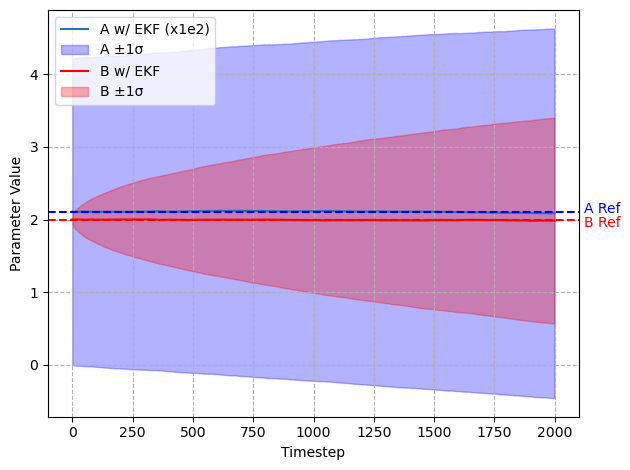

In [6]:
fig = plt.figure()
ax = fig.gca()

A_mean, A_spread = A_hist[:, 0], A_hist[:, 1]
xtime = range(0, nSteps)
plt.plot(xtime, A_mean, label="A w/ EKF (x1e2)")
plt.fill_between(
    xtime,
    A_mean - A_spread,
    A_mean + A_spread,
    alpha=0.3,
    color="blue",
    label="A ±1σ",
)
plt.axhline(A_ref, color="blue", linestyle="--")

B_mean, B_spread = B_hist[:, 0], B_hist[:, 1]
plt.plot(xtime, B_mean, label="B w/ EKF ", color="red")
plt.fill_between(
    xtime,
    B_mean - B_spread,
    B_mean + B_spread,
    alpha=0.3,
    color="red",
    label="B ±1σ",
)
plt.axhline(B_ref, color="red", linestyle="--")

xmax = ax.get_xlim()[1]
plt.text(xmax + 0.01 * xmax, A_ref + 0.05, "A Ref", color="blue", va="center")
plt.text(xmax + 0.01 * xmax, B_ref - 0.05, "B Ref", color="red", va="center")

plt.xlabel("Timestep")
plt.ylabel("Parameter Value")
plt.legend(loc="upper left")
plt.grid(ls="--")
plt.tight_layout()
plt.show()

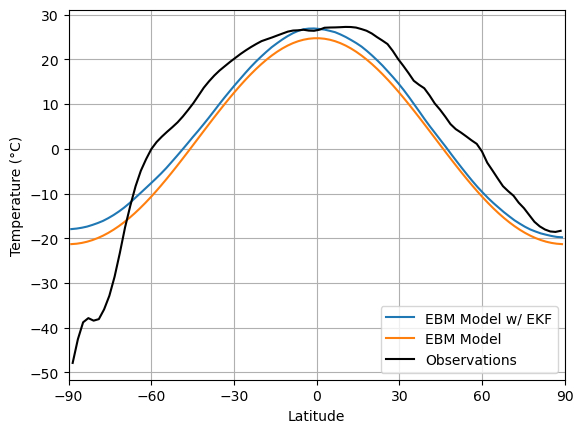

In [7]:
fig = plt.figure()
ax = fig.gca()
ax.plot(ebm.lat, ebm.Ts, label="EBM Model w/ EKF")
ax.plot(climlab_ebm.lat, climlab_ebm.Ts, label="EBM Model")
ax.plot(lat_ncep, Ts_ncep_annual, label="Observations", c="k")
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Latitude")
ax.set_xlim(-90, 90)
ax.set_xticks(np.arange(-90, 91, 30))
ax.legend()
ax.grid()

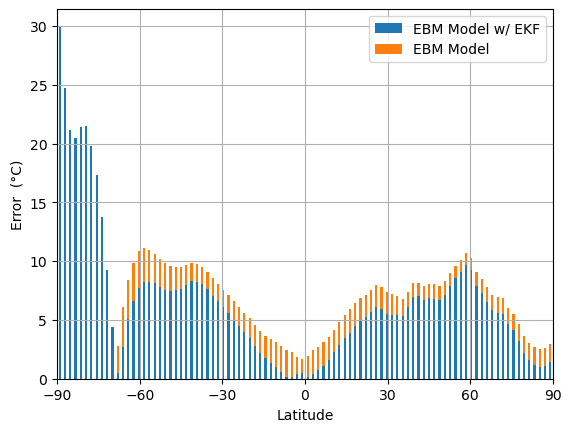

In [8]:
fig = plt.figure()
ax = fig.gca()
ax.bar(
    x=ebm.lat,
    height=np.abs(ebm.Ts.reshape(-1) - Ts_ncep_annual.values),
    label="EBM Model w/ EKF",
)
ax.bar(
    x=climlab_ebm.lat,
    height=np.abs(climlab_ebm.Ts.reshape(-1) - Ts_ncep_annual.values),
    label="EBM Model",
    zorder=-1,
)
ax.set_ylabel("Error  (°C)")
ax.set_xlabel("Latitude")
ax.set_xlim(-90, 90)
ax.set_xticks(np.arange(-90, 91, 30))
ax.legend()
ax.grid()

In [9]:
np.mean((ebm.Ts.reshape(-1) - Ts_ncep_annual.values) ** 2)

Field(73.46155477)

In [10]:
np.mean((climlab_ebm.Ts.reshape(-1) - Ts_ncep_annual.values) ** 2)

Field(77.76398962)